# Navigator FT with Differential Privacy: Experiments

In this notebook, we generate synthetic tabular data using Navigator FT, which allows us to work with both numerical/categorical and free-text columns. We demonstrate how to do that with differential privacy (DP), and compare the performance of the model with and without DP.

## Prepare dataset

We use an e-commerce dataset that contains free-text reviews as well as other numerical/categorical columns such as rating, product tags, customer age etc.

In [1]:
from datasets import load_dataset

ds = load_dataset("saattrupdan/womens-clothing-ecommerce-reviews")

In [2]:
df_train = ds["train"].to_pandas()

# For simplicity, we remove non-standard chars and truncate the review text
df_train["review_text"] = df_train["review_text"].str.replace(r'[^A-Za-z0-9 \.!?\']+', '', regex=True)
df_train["review_text"] = df_train["review_text"].str.slice(0, 128)

df_train

,review_text,age,rating,positive_feedback_count,division_name,department_name,class_name,recommended_ind
0,I loved this shirt until the first time i wash...,39,1,0,General,Tops,Knits,0
1,This sweater was unflattering me very boxy and...,44,3,0,General,Tops,Sweaters,0
2,I fell in love with these bottoms at first sit...,41,5,2,General,Bottoms,Pants,1
3,I love the dress! i purchased this dress to w...,34,5,0,General,Dresses,Dresses,1
4,I fell in love with this dress when i saw it o...,46,5,0,General Petite,Dresses,Dresses,1
...,...,...,...,...,...,...,...,...
20636,I really liked these jeans initially but by th...,25,3,1,General,Bottoms,Jeans,0
20637,This top is soo pretty with a cool edge.it loo...,45,5,0,General Petite,Tops,Blouses,1
20638,I absolutely love this top. i'm always either ...,49,5,1,General Petite,Tops,Blouses,1
20639,Tts bought my usual pilcro size. enjoy the fi...,31,4,0,General Petite,Bottoms,Jeans,1


## Submit experiment

We first set up a generic config that we can use either with or without DP.

In [ ]:
YAML_CONFIG = lambda dp, epsilon, run_id: f"""
    schema_version: 1.0
    name: "ecommerce-data-{f'dp-eps{epsilon}' if dp else 'nodp'}-run{run_id}"
    models:
    - navigator_ft:
        group_training_examples_by: null
        order_training_examples_by: null

        params:
            num_input_records_to_sample: auto
            batch_size: {8 if dp else 1}

        privacy_params:
            dp: {'true' if dp else 'false'}
            epsilon: {epsilon}

        generate:
            num_records: 1000
            use_structured_generation: {'true' if dp else 'false'}
"""

Next, we instantiate a Gretel client so that we can submit the experiments, and then launch many of them - both with and without DP, and for multiple values of epsilon. For each, we run it 5 times so that we can have some idea of the variance.

In [ ]:
from gretel_client import Gretel

PROJECT_NAME = "navft-dp-experiments"

gretel = Gretel(api_key="prompt", project_name=PROJECT_NAME, validate=True)

Found cached Gretel credentials
Using endpoint https://api-dev.gretel.cloud
Logged in as andre.manoel@gretel.ai ✅
Project URL: https://console-dev.gretel.ai/proj_2oXOdB3gtbWUN81I9lEHQJORrT0


In [ ]:
# Run training
for i in range(5):
    for dp in [False, True]:
        if dp:
            for epsilon in [2, 4, 8, 16]:
                    print(f'Submitting exp w/ DP, epsilon {epsilon}, run {i}')
                    model = gretel.submit_train(
                        base_config=YAML_CONFIG(dp=True, epsilon=epsilon, run_id=i + 1),
                        data_source=df_train,
                        wait=False,
                    )
        else:
                print(f'Submitting exp w/ no DP, run {i}')
                model = gretel.submit_train(
                    base_config=YAML_CONFIG(dp=False, epsilon=8, run_id=i + 1),
                    data_source=df_train,
                    wait=False,
                )

## Analyze results

You can check on the dashboard to see if experiments are running, hopefully you did not see any error!

After they all finish, we can run the snippet below to fetch and parse metrics we are interested in.

In [ ]:
import re
import pandas as pd

results = pd.DataFrame(columns=['dataset', 'eps', 'exp_type', 'run_id', 'sqs', 'dps', 'failed_runs', 'oom', 'valid_records', 'training_runtime', 'generation_runtime'])

for m in gretel._project.search_models(limit=200):
    name = m.name
    start_time = pd.to_datetime(m.logs[0]['ts'])

    model_id = m.model_id
    errors = m.errors
    config_params = m.model_config['models'][0]['navigator_ft']['params']
    generate_params = m.model_config['models'][0]['navigator_ft']['generate']

    print(f'Processing {name}')
    dataset = 'ecommerce-data'
    name = name.removeprefix('ecommerce-data-')
    *exp_type, run_id = name.split('-')
    if exp_type[0] == 'nodp':
        exp_type, = exp_type
        eps = None
    elif exp_type[0] == 'dpsetup':
        exp_type, = exp_type
        eps = None
    else:
        exp_type, eps = exp_type
        eps = float(eps.replace('eps', ''))
    run_id = int(run_id.replace('run', ''))

    oom = 'noise multiplier' in m.logs[-1]['msg'] or \
        'Training' in m.logs[-1]['msg']

    report = m.get_report_summary()
    if report is None:
        results.loc[len(results)] = dataset, eps, exp_type, run_id, None, None, 1.0 if not oom else 0.0, oom, None, None, None 
        print(f' Skipping, report not found...')
        continue
    sqs = report['summary'][0]['value']
    dps = report['summary'][-1]['value']

    rounds, pvr = 0, 0.0
    for l in m.logs:
        if "records that are valid" in l['msg']:
            rounds += 1
            regex_match = re.search(r"records that are valid: (.*)\%\n", l['msg'], re.DOTALL)
            if regex_match:
                pvr += float(regex_match.group(1))
    pvr /= rounds

    for log in m.logs:
        if 'Training Completed' in log['msg']:
            end_training = pd.to_datetime(log['ts'])
        if 'Generation complete' in log['msg']:
            end_generation = pd.to_datetime(log['ts'])

    training_runtime = (end_training - start_time).total_seconds()
    generation_runtime = (end_generation - end_training).total_seconds()

    results.loc[len(results)] = dataset, eps, exp_type, run_id, sqs, dps, 0.0, 0.0, pvr, training_runtime, generation_runtime

Processing ecommerce-data-nodp-run3
Processing ecommerce-data-nodp-run1
Processing ecommerce-data-nodp-run4
Processing ecommerce-data-nodp-run2
Processing ecommerce-data-nodp-run5
Processing ecommerce-data-dp-eps4-run2
Processing ecommerce-data-dp-eps2-run5
Processing ecommerce-data-dp-eps16-run5
Processing ecommerce-data-dp-eps8-run5
Processing ecommerce-data-dp-eps16-run3
Processing ecommerce-data-dp-eps2-run1
Processing ecommerce-data-dp-eps2-run3
Processing ecommerce-data-dp-eps2-run2
Processing ecommerce-data-dp-eps2-run4
Processing ecommerce-data-dp-eps8-run4
Processing ecommerce-data-dp-eps8-run1
Processing ecommerce-data-dp-eps4-run4
Processing ecommerce-data-dp-eps16-run4
Processing ecommerce-data-dp-eps4-run1
Processing ecommerce-data-dp-eps8-run2
Processing ecommerce-data-dp-eps4-run5
Processing ecommerce-data-dp-eps4-run3
Processing ecommerce-data-dp-eps16-run1
Processing ecommerce-data-dp-eps16-run2
Processing ecommerce-data-dp-eps8-run3


Let's take a quick look at the metrics, before plotting, to see if everything looks okay.

In [6]:
results

,dataset,eps,exp_type,run_id,sqs,dps,failed_runs,oom,valid_records,training_runtime,generation_runtime
0,ecommerce-data,NaN,nodp,3,87,89,0.0,0.0,88.390000,349.033665,108.273913
1,ecommerce-data,NaN,nodp,1,84,88,0.0,0.0,89.680000,345.055663,110.271270
2,ecommerce-data,NaN,nodp,4,88,88,0.0,0.0,90.230000,348.467848,109.088167
3,ecommerce-data,NaN,nodp,2,89,87,0.0,0.0,84.500000,344.485172,107.506290
4,ecommerce-data,NaN,nodp,5,87,88,0.0,0.0,87.380000,347.032660,110.384238
5,ecommerce-data,4.0,dp,2,71,89,0.0,0.0,100.000000,1035.217333,318.992810
6,ecommerce-data,2.0,dp,5,78,88,0.0,0.0,99.900000,1039.704994,291.265489
7,ecommerce-data,16.0,dp,5,73,88,0.0,0.0,100.000000,1041.420892,347.800474
8,ecommerce-data,8.0,dp,5,76,90,0.0,0.0,100.000000,1040.726329,337.093886
9,ecommerce-data,16.0,dp,3,79,89,0.0,0.0,100.000000,1041.697013,391.200308


Finally, we do some plots.

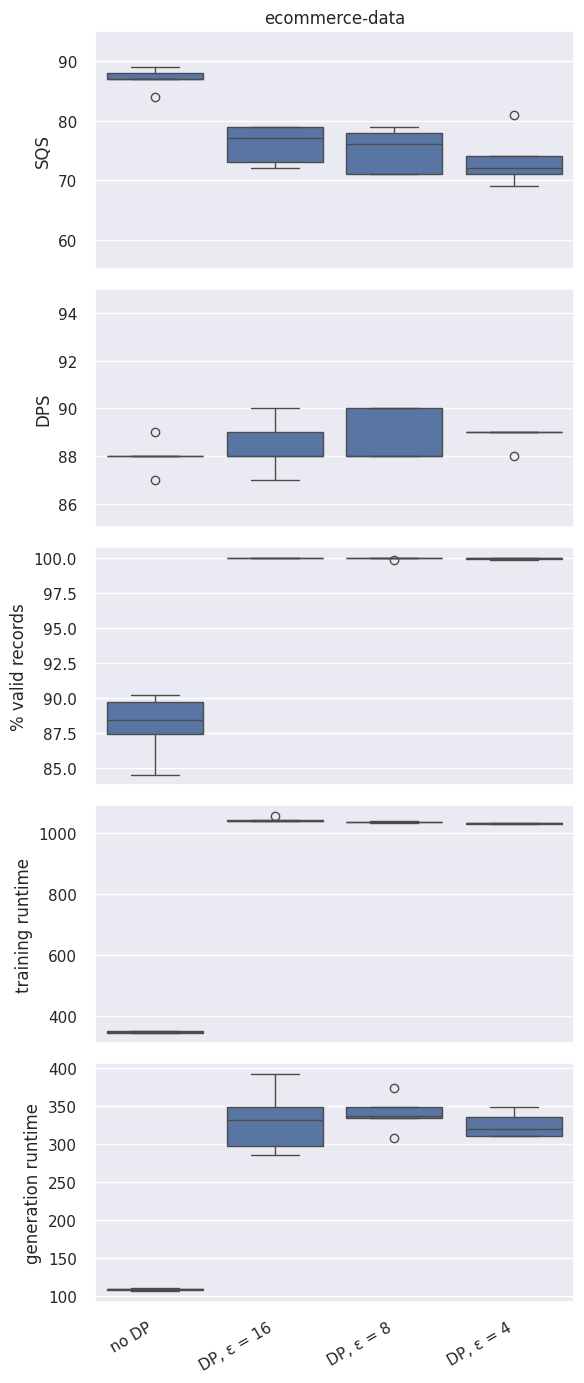

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

df = results.copy()
df['exp'] = df['exp_type'] + ', eps ' + df['eps'].astype(str)
df.drop(columns=['exp_type', 'eps'], inplace=True)
df = df.melt(id_vars=['dataset', 'exp', 'run_id'])

order = ['nodp, eps nan', 'dp, eps 16.0', 'dp, eps 8.0', 'dp, eps 4.0']
x_labels = ['no DP', 'DP, ε = 16', 'DP, ε = 8', 'DP, ε = 4']
y_labels = ['SQS', 'DPS', '% valid records', 'training runtime', 'generation runtime']

fig, axs = plt.subplots(5, 1, figsize=(6, 14))
for j, dataset in enumerate(df.dataset.unique()):
    for i, var in enumerate(['sqs', 'dps', 'valid_records', 'training_runtime', 'generation_runtime']):
        ax = axs[i]

        subdf = df[(df['dataset'] == dataset) & (df['variable'] == var)]
        sns.boxplot(data=subdf, x='exp', y='value', ax=ax, order=order)

        ax.set_ylabel(y_labels[i])
        ax.set_xlabel('')
        if i == 0:
            ax.set_title(dataset)
        if i != len(axs) - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xticklabels(x_labels, rotation=30, ha='right')

axs[0].set_ylim([55, 95])
axs[1].set_ylim([85, 95])
fig.set_tight_layout(tight=True)

Trends observed are as expected: SQS go down as we decrease epsilon, and DPS goes up. The percentage of valid records is 100% due to the use of structured generation. Training and generation time increase considerably, due to changes required for DP.

## Downstream task

Something else we are interested in is how the synthetic data can be used, and if it provides similar results to the original data. For instance, we could look at some analytics, such as the distribution of ratings in a given category.

We load synthetic records generated in the above experiments; the DP one uses epsilon = 8.

In [ ]:
orig_data = df_train.sample(n=2000)
train_data, test_data = orig_data[:1000], orig_data[1000:]
synth_data_nodp = pd.read_json("https://gretel-blueprints-pub.s3.us-west-2.amazonaws.com/navft/dp_blogpost/ecomm_synth_nodp.jsonl", lines=True)
synth_data_dp = pd.read_json("https://gretel-blueprints-pub.s3.us-west-2.amazonaws.com/navft/dp_blogpost/ecomm_synth_dp.jsonl", lines=True)

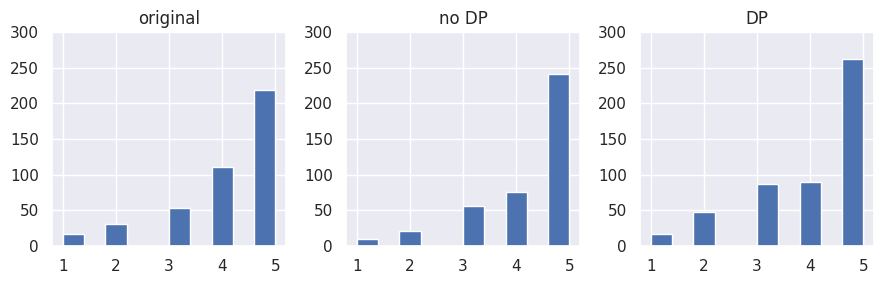

In [9]:
names = ["original", "no DP", "DP"]

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i, d in enumerate([train_data, synth_data_nodp, synth_data_dp]):
    ax = axs[i]
    d.loc[d.department_name == 'Tops'].rating.hist(ax=ax)
    ax.set_ylim([0, 300])
    ax.set_title(names[i])

fig.set_tight_layout(tight=True)

DP results are slightly more concentrated, as DP is known to make infrequent values even more infrequent. We can also see, e.g., if we can use the synthetic data to predict the rating from the review text.

In [ ]:
from sentence_transformers import SentenceTransformer
from pycaret import classification

transform = SentenceTransformer("all-MiniLM-L6-v2")

def get_downstream_metrics(train_data, test_data):
    train_embeddings = transform.encode(train_data.review_text.to_list())
    train_downstream_data = pd.DataFrame(train_embeddings)
    train_downstream_data['target'] = train_data.rating.reset_index(drop=True)

    test_embeddings = transform.encode(test_data.review_text.to_list())
    test_downstream_data = pd.DataFrame(test_embeddings)
    test_downstream_data['target'] = test_data.rating.reset_index(drop=True)

    exp = classification.setup(data=train_downstream_data, target='target', verbose=False)
    model = exp.create_model(estimator='lr', verbose=False)
    exp.predict_model(estimator=model, data=test_downstream_data)

get_downstream_metrics(train_data=train_data, test_data=test_data)

2024-11-13 21:50:30.349896: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-13 21:50:30.507833: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-13 21:50:31.254480: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-11-13 21:50:31.254594: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5740,0.6723,0.5961,0.4849,0.4956,0.0905,0.1166


In [11]:
get_downstream_metrics(train_data=synth_data_nodp, test_data=test_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5690,0.6798,0.5909,0.4250,0.4662,0.0419,0.0645


In [12]:
get_downstream_metrics(train_data=synth_data_dp, test_data=test_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5690,0.6236,0.5909,0.3973,0.4572,0.0307,0.0544


Once again, we can see that DP gives slightly worse results, but good enough considering the protection that it adds.